In [3]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark
!pip install xgboost pyspark


In [12]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [1]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 10:37:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [3]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
import networkx as nx
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")


In [6]:
data_path='/kaggle/input/transactions-data-big-data/Transactions Data V2.0'


# Read the data

In [7]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [8]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)


# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+----+-------+----------+---------+-------+------+-----------------+-----------+---------------+--------+------+--------------------+
| mcc|     id|      date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city|  errors|target|         description|
+----+-------+----------+---------+-------+------+-----------------+-----------+---------------+--------+------+--------------------+
|4121|7475341|2010-01-01|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|No Error|    No|Taxicabs and Limo...|
|5541|7475347|2010-01-01|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|No Error|    No|    Service Stations|
|4121|7475378|2010-01-01|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|No Error|    No|Taxicabs and Limo...|
+----+-------+----------+---------+-------+------+-----------------+-----------+---------------+--------+------+--------------------+
only showing top 3 rows



In [9]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)


# Check the count of rows
cards_df.count()

4514

In [10]:
cards_df.printSchema()
users_df.printSchema()
transactions_df.printSchema()

root
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- expires: string (nullable = true)
 |-- cvv: integer (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- acct_open_date: string (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)

root
 |-- client_id: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- per_capita_income: double (nullable = true)


In [24]:
trans_cards_df = transactions_df.join(cards_df, on=["client_id", "card_id"], how="left")

final_df = trans_cards_df.join(users_df, on="client_id", how="left")
columns_to_drop = ["id","client_id","card_id","merchant_id","card_on_dark_web","longitude","latitude","date", "card_number", "expires", "cvv", "acct_open_date", "address","description"]
final_df = final_df.drop(*columns_to_drop)
final_df = final_df.withColumn(
    "merchant_city",
    when(F.lower(F.col("merchant_city")) == "online", "online").otherwise("other")
)
final_df.printSchema()
final_df = final_df.na.fill("Unknown")  # for categorical
final_df = final_df.na.fill(0) 
label_indexer = StringIndexer(inputCol="target", outputCol="label")
final_df = label_indexer.fit(final_df).transform(final_df)
##Convert Categorical Columns
categorical_cols = [col for col, dtype in final_df.dtypes if dtype == 'string' and col != 'target']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx").fit(final_df) for col in categorical_cols]

for indexer in indexers:
    final_df = indexer.transform(final_df)

# Drop original string columns (except 'target' which is your label)
final_df = final_df.drop(*categorical_cols)


root
 |-- mcc: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_city: string (nullable = false)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- per_capita_income: double (nullable = true)
 |-- yearly_income: double (nullable = true)
 |-- total_debt: double (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)



In [25]:
final_df.printSchema()

root
 |-- mcc: integer (nullable = true)
 |-- amount: double (nullable = false)
 |-- target: string (nullable = false)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = false)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- per_capita_income: double (nullable = false)
 |-- yearly_income: double (nullable = false)
 |-- total_debt: double (nullable = false)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- use_chip_idx: double (nullable = false)
 |-- merchant_city_idx: double (nullable = false)
 |-- errors_idx: double (nullable = false)
 |-- card_brand_idx: double (nullable = false)
 |-- card_type_idx: double (nullable = false)
 |-- has_chip_idx: double (nullable = false)
 |-- gen

In [26]:

feature_cols = [col for col in final_df.columns if col not in ["target", "label" ]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_df = assembler.transform(final_df)
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)


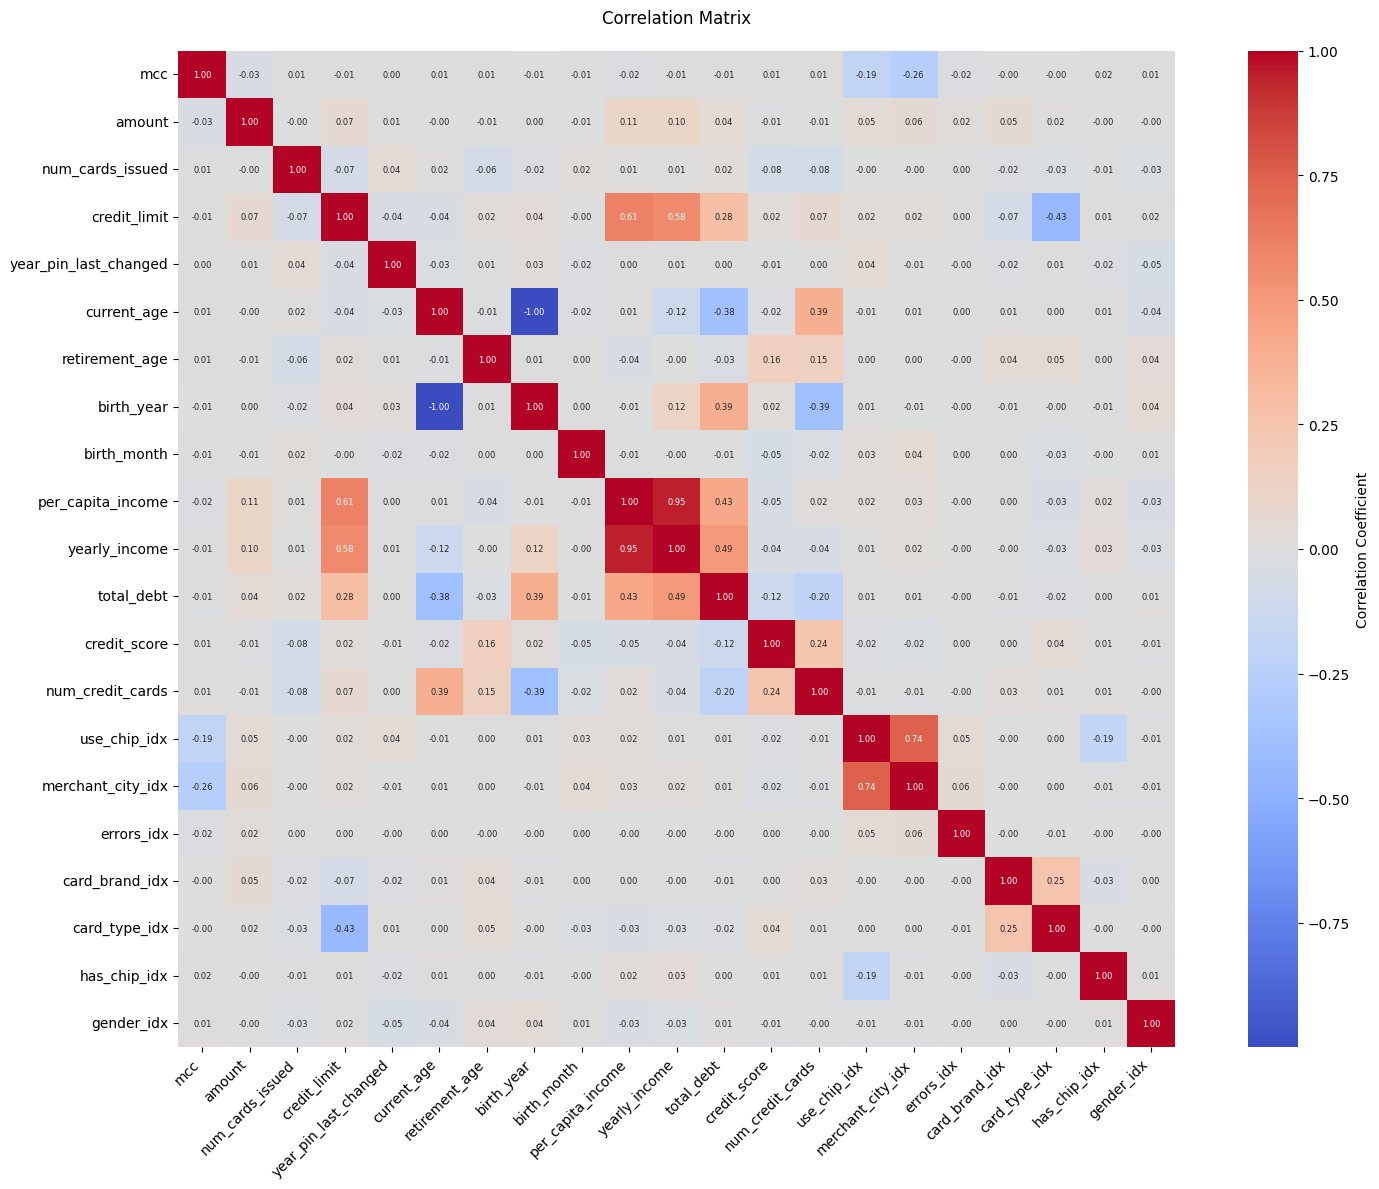

In [27]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the correlation matrix
correlation_matrix = Correlation.corr(final_df, "features", method="pearson").head()
corr_array = correlation_matrix[0].toArray()

# Step 2: Plot the Correlation Matrix with improved readability
plt.figure(figsize=(16, 12))  # Increase figure size for better spacing
sns.heatmap(
    corr_array, 
    annot=True, 
    fmt=".2f",  # Limit to 2 decimal places
    annot_kws={"size": 6},  # Reduce font size of annotations
    cmap='coolwarm', 
    xticklabels=feature_cols, 
    yticklabels=feature_cols,
    cbar_kws={'label': 'Correlation Coefficient'},  # Add label to color bar
    square=True  # Ensure cells are square for better proportion
)

# Rotate labels to avoid overlap
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for readability
plt.title("Correlation Matrix", pad=20)  # Add padding to title
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('correlation_matrix.png')  # Save the plot instead of showing it

# logisitc regression

In [28]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)


25/04/28 11:20:25 WARN MemoryStore: Not enough space to cache rdd_775_1 in memory! (computed 17.0 MiB so far)
25/04/28 11:20:25 WARN BlockManager: Persisting block rdd_775_1 to disk instead.
25/04/28 11:20:25 WARN MemoryStore: Not enough space to cache rdd_775_0 in memory! (computed 17.0 MiB so far)
25/04/28 11:20:25 WARN BlockManager: Persisting block rdd_775_0 to disk instead.
25/04/28 11:20:26 WARN MemoryStore: Not enough space to cache rdd_775_2 in memory! (computed 33.0 MiB so far)
25/04/28 11:20:26 WARN BlockManager: Persisting block rdd_775_2 to disk instead.
25/04/28 11:20:29 WARN MemoryStore: Not enough space to cache rdd_775_3 in memory! (computed 65.0 MiB so far)
25/04/28 11:20:29 WARN BlockManager: Persisting block rdd_775_3 to disk instead.
25/04/28 11:20:46 WARN MemoryStore: Not enough space to cache rdd_775_5 in memory! (computed 17.0 MiB so far)
25/04/28 11:20:46 WARN BlockManager: Persisting block rdd_775_5 to disk instead.
25/04/28 11:20:47 WARN MemoryStore: Not enoug

# random forest

In [29]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)


25/04/28 11:24:24 WARN MemoryStore: Not enough space to cache rdd_892_2 in memory! (computed 8.6 MiB so far)
25/04/28 11:24:24 WARN BlockManager: Persisting block rdd_892_2 to disk instead.
25/04/28 11:24:24 WARN MemoryStore: Not enough space to cache rdd_892_3 in memory! (computed 8.6 MiB so far)
25/04/28 11:24:24 WARN BlockManager: Persisting block rdd_892_3 to disk instead.
25/04/28 11:24:24 WARN MemoryStore: Not enough space to cache rdd_892_1 in memory! (computed 13.1 MiB so far)
25/04/28 11:24:24 WARN BlockManager: Persisting block rdd_892_1 to disk instead.
25/04/28 11:24:26 WARN MemoryStore: Not enough space to cache rdd_892_0 in memory! (computed 46.4 MiB so far)
25/04/28 11:24:26 WARN BlockManager: Persisting block rdd_892_0 to disk instead.
25/04/28 11:24:40 WARN MemoryStore: Not enough space to cache rdd_892_3 in memory! (computed 104.7 MiB so far)
25/04/28 11:24:40 WARN MemoryStore: Not enough space to cache rdd_892_0 in memory! (computed 104.7 MiB so far)
25/04/28 11:24:4

# XGBoost

In [31]:
from xgboost.spark import SparkXGBClassifier

# Calculate scale_pos_weight manually if needed: (num_negative / num_positive)
# Example: scale_pos_weight = 10 if positives are much fewer.

xgb = SparkXGBClassifier(
    features_col="features",
    label_col="label",
    prediction_col="prediction",
    max_depth=5,
    eta=0.1,
    num_round=50,
    num_workers=2,  # adjust based on your cluster
    scale_pos_weight=10,          # IMPORTANT: positive_class_weight = (negatives / positives)
    eval_metric='aucpr'           # Precision-Recall curve metric is better than accuracy for imbalance
)

# Fit the model and make predictions
xgb_model = xgb.fit(train_data)
xgb_predictions = xgb_model.transform(test_data)


[11:42:54] task 0 got new rank 0                                                        (0 + 2) / 2]
[11:42:54] task 1 got new rank 1
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:43:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:43:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)


# SVM

In [32]:
from pyspark.ml.classification import LinearSVC

# Train SVM model
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)


25/04/28 11:45:32 WARN MemoryStore: Not enough space to cache rdd_1028_1 in memory! (computed 17.0 MiB so far)
25/04/28 11:45:32 WARN BlockManager: Persisting block rdd_1028_1 to disk instead.
25/04/28 11:45:32 WARN MemoryStore: Not enough space to cache rdd_1028_3 in memory! (computed 17.0 MiB so far)
25/04/28 11:45:32 WARN BlockManager: Persisting block rdd_1028_3 to disk instead.
25/04/28 11:45:32 WARN MemoryStore: Not enough space to cache rdd_1028_0 in memory! (computed 33.0 MiB so far)
25/04/28 11:45:32 WARN BlockManager: Persisting block rdd_1028_0 to disk instead.
25/04/28 11:45:35 WARN MemoryStore: Not enough space to cache rdd_1028_2 in memory! (computed 65.0 MiB so far)
25/04/28 11:45:35 WARN BlockManager: Persisting block rdd_1028_2 to disk instead.
25/04/28 11:45:52 WARN MemoryStore: Not enough space to cache rdd_1028_6 in memory! (computed 17.0 MiB so far)
25/04/28 11:45:52 WARN BlockManager: Persisting block rdd_1028_6 to disk instead.
25/04/28 11:45:53 WARN MemoryStore:

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Binary AUC evaluator (for ROC curve)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Multiclass evaluator for precision, recall, F1
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

def evaluate_model(predictions, model_name="Model"):
    print(f"=== {model_name} ===")
    print("AUC:", binary_evaluator.evaluate(predictions))
    print("Weighted Precision:", multiclass_evaluator.setMetricName("weightedPrecision").evaluate(predictions))
    print("Weighted Recall:", multiclass_evaluator.setMetricName("weightedRecall").evaluate(predictions))
    print("F1 Score:", multiclass_evaluator.setMetricName("f1").evaluate(predictions))

    print()

# Run evaluation
evaluate_model(lr_predictions, "Logistic Regression")
evaluate_model(rf_predictions, "Random Forest")
evaluate_model(xgb_predictions, "XGBoost")
evaluate_model(svm_predictions, "SVM")


=== Logistic Regression ===


AUC: 0.8415441218775166


Weighted Precision: 0.9973110213774752


Weighted Recall: 0.9984548853450869


F1 Score: 0.9976940990986647

=== Random Forest ===


AUC: 0.8429923416538831


Weighted Precision: 0.998570266420582


Weighted Recall: 0.9985682161948662


F1 Score: 0.9979464688544487

=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cu

AUC: 0.9528813442108208


Weighted Precision: 0.9985834146183611


Weighted Recall: 0.9987062329723204


F1 Score: 0.9986345730054459

=== SVM ===


AUC: 0.821222663465123


Weighted Precision: 0.9969233616396229


Weighted Recall: 0.9984604957831947


F1 Score: 0.997691336649544



In [34]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictions_and_labels = xgb_predictions.select("prediction", "label").rdd

metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix()

print("Confusion Matrix for XGBoost:")
print(confusion_matrix)

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceb

Confusion Matrix for XGBoost:
DenseMatrix([[1.778769e+06, 8.790000e+02],
             [1.427000e+03, 1.317000e+03]])


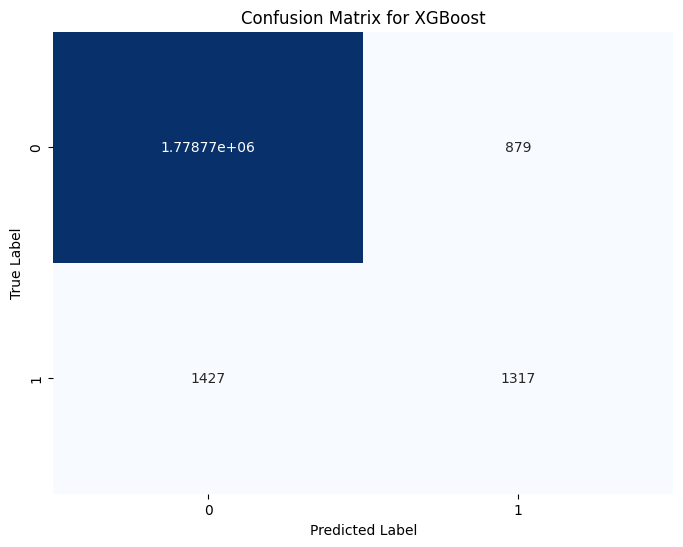

In [35]:

# Extracting the confusion matrix as a NumPy array
confusion_matrix_np = confusion_matrix.toArray()

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=True, yticklabels=True)

# Adding labels and title
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
